In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D,Conv2D,MaxPooling2D,AveragePooling2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from keras.layers import Input,Activation,Dense,Flatten,Concatenate,Lambda,TimeDistributed,Reshape
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
import six
from keras.models import Model

Using TensorFlow backend.


In [2]:
# Resnet layer (architecture adapted from https://github.com/raghakot/keras-resnet/blob/master/resnet.py)

In [3]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier

class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        model = Sequential()
        lambda_layer = Lambda(lambda block:block, input_shape=input_shape)
        #time_dist_layer = TimeDistributed(lambda_layer, input_shape=input_shape)
        model.add(lambda_layer)
        
        filters = 64
        for i, r in enumerate(repetitions):
            #block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))
            lambda_layer = Lambda(block)
            #lambda_layer = Lambda(lambda block:block)
            #time_dist_layer = TimeDistributed(lambda_layer)
            model.add(lambda_layer)
            filters *= 2
        
        return model  

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [14]:
input_shape = (3,224,224)
num_outputs = None
resnet50 = ResnetBuilder.build_resnet_50(input_shape, num_outputs)

# Output dimensions of the resnet layer are (None, 28, 28, 2048)
# They need to be converted to (None, time_steps, 28, 28, 2048)
# so that they can be sent to the 2DconvLSTM model
# resnet50.add(Reshape((-1,28,28,2048), input_shape=(28,28,2048)))

In [15]:
# Display model characteristics
resnet50.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 224, 224, 256)     0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 112, 112, 512)     0         
_________________________________________________________________
lambda_9 (Lambda)            (None, 56, 56, 1024)      0         
_________________________________________________________________
lambda_10 (Lambda)           (None, 28, 28, 2048)      0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Add the 2D convolutional LSTM layers here
# resnet50.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                    input_shape=(None, 28, 28, 2048),
#                    padding='same', return_sequences=True))
# resnet50.add(BatchNormalization())

# resnet50.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# resnet50.add(BatchNormalization())

# resnet50.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# resnet50.add(BatchNormalization())

# resnet50.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# resnet50.add(BatchNormalization())

# resnet50.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
#                activation='sigmoid',
#                padding='same', data_format='channels_last'))

In [17]:
# print(resnet50)
# print(resnet50.summary())

(1, 224, 224, 3)


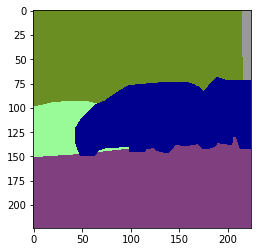

In [18]:
# Get input image for testing purposes
img = []
img.append(skimage.io.imread('./gtFine_trainvaltest/gtFine/train/erfurt/erfurt_000000_000019_gtFine_color.png'))

# Crop the section of the image that will be run through the network (224x224x3)
img_crop = np.array(img[0][350:574,500:724,:3])
img_feed = np.reshape(img_crop, [-1,224,224,3])
plt.figure()
plt.imshow(img_crop)
print(img_feed.shape)

# Run the model through the network here


# Each of the layers in the ResNet model will produce different features.
# These features will need to be concatenated (after up-sampling or down-sampling)
# and the result will be an array of skip features


# An estimate of the first datapoint will have to be produced
# The estimate will be created in terms of a map with the same dimensions as the skip feature map
# The results will be concatenated


# The result of the operations above will be fed to the ConvLSTM2D for temporal feature analysis


# The output will be fed into an evaluation network along with some other inputs




In [19]:
resnet50.compile(loss='binary_crossentropy', optimizer='adadelta')

In [20]:
result = resnet50.predict(img_feed)

(1, 28, 28, 2048)


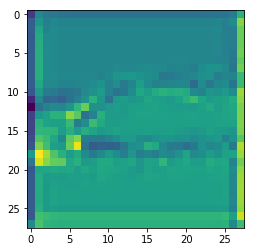

In [33]:
print(result.shape)
plt.imshow(np.squeeze(result[0,:,:,0]))

In [ ]:
# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

# seq.compile(loss='binary_crossentropy', optimizer='adadelta')

# seq.summary()

# model = Model(resnet50,seq)

# model.summary()

In [ ]:
# # Train the network
# seq.fit(train_data, valid_data, batch_size=10,
#         epochs=3, validation_split=0.05)